# Imports 

In [1]:
from helpers import *
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import ast

import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.graph_objects as go

# Préparation des données

In [2]:
def create_datasets(file_source = '', reviews_source = ''):
    # MetaData 

    #### Movie metadata #### DF
    MovieMetadata_df = pd.read_csv(file_source +'MovieSummaries/movie.metadata.tsv', sep="\t",  header=None)

    #### Character metadata #### DF
    CharacterMetadata_df = pd.read_csv(file_source + 'MovieSummaries/character.metadata.tsv',sep="\t", header=None)

    # Define column headers as a list
    MovieMetadata_df_headers = [
        'Wikipedia movie ID',
        'Freebase movie ID',
        'Movie name',
        'Movie release date',
        'Movie box office revenue',
        'Movie runtime',
        'Movie languages (Freebase ID:name tuples)',
        'Movie countries (Freebase ID:name tuples)',
        'Movie genres (Freebase ID:name tuples)'
    ]

    MovieMetadata_df.columns = MovieMetadata_df_headers

    # Define column headers for the second dataset
    CharacterMetadata_df_headers = [
        'Wikipedia movie ID',
        'Freebase movie ID',
        'Movie release date',
        'Character name',
        'Actor date of birth',
        'Actor gender',
        'Actor height (in meters)',
        'Actor ethnicity (Freebase ID)',
        'Actor name',
        'Actor age at movie release',
        'Freebase character/actor map ID',
        'Freebase character ID',
        'Freebase actor ID'
    ]

    CharacterMetadata_df.columns = CharacterMetadata_df_headers

    # Text data 
    names_df = pd.read_csv(file_source+'MovieSummaries/name.clusters.txt', sep="\t", header=None)
    plot_summaries_df = pd.read_csv(file_source+'MovieSummaries/plot_summaries.txt', sep="\t",header=None)
    tvTropes_df = pd.read_csv(file_source+'MovieSummaries/tvtropes.clusters.txt',sep="\t", header=None)

    names_df_headers = [
        'Character Names',
        'Instances'
    ]

    names_df.columns = names_df_headers

    tvTropes_df_headers = [
        'Character Types',
        'Instances'
    ]

    tvTropes_df.columns = tvTropes_df_headers


    plot_summaries_df_headers = [
        'Wikipedia movie ID',
        'Summaries'
    ]

    plot_summaries_df.columns = plot_summaries_df_headers

    reviews = pd.read_csv(reviews_source)

    merged_Movie = MovieMetadata_df.merge(reviews, how='left', left_on = 'Movie name', right_on = 'title')


    # Function to extract the year
    def extract_year(date_str):
        if pd.isna(date_str):  # Check if the value is NaN
            return None  # Return None or a suitable placeholder for NaN
        if len(date_str) == 4:  # Check if it's a four-digit year
            return int(date_str)  # Return the year as an integer
        return pd.to_datetime(date_str, errors='coerce').year  # Convert to datetime and extract year


    # Extract the year without modifying the original column
    MovieMetadata_df['Year'] = MovieMetadata_df['Movie release date'].apply(extract_year)
    #MovieMetadata_df['Year'] = MovieMetadata_df['Year'].apply(lambda x: int(x) if pd.notna(x) else x)
    MovieMetadata_df['Year'] = pd.to_numeric(MovieMetadata_df['Year'], errors='coerce').astype('Int64')

    CharacterMetadata_df['Year'] = CharacterMetadata_df['Movie release date'].apply(extract_year)
    CharacterMetadata_df['Year'] = pd.to_numeric(CharacterMetadata_df['Year'], errors='coerce').astype('Int64')


    return MovieMetadata_df, CharacterMetadata_df, names_df, plot_summaries_df, tvTropes_df, merged_Movie


In [3]:
# Just fill this with wherever is your main data folder is (copy the path just before 'MovieSummaries'):
file_source = ""

# Same goes for the reviews dataset : but simply copy the entire path of where your reviews data is... 
reviews_path = "TMDB_movie_dataset_v11.csv"

### creating dataset by extracting the main CMU data ###
MovieMetadata_df, CharacterMetadata_df, names_df, plot_summaries_df, tvTropes_df, merged_Movie = create_datasets(file_source, reviews_path)

reviews = pd.read_csv(reviews_path)

MovieMetadata_df['Country dictionnaire'] = MovieMetadata_df['Movie countries (Freebase ID:name tuples)'].apply(ast.literal_eval)
MovieMetadata_df['Genre dictionnaire'] = MovieMetadata_df['Movie genres (Freebase ID:name tuples)'].apply(ast.literal_eval)
MovieMetadata_df['Language dictionnaire'] = MovieMetadata_df['Movie languages (Freebase ID:name tuples)'].apply(ast.literal_eval)

In [4]:
#Jointure Country/Genre in CharacterMetadata_df

MovieMetadata_df_filtered = MovieMetadata_df[['Wikipedia movie ID', 'Movie countries (Freebase ID:name tuples)',
                                              'Movie genres (Freebase ID:name tuples)', 'Country dictionnaire', 'Genre dictionnaire' ]]

CharacterMetadata_df = pd.merge(CharacterMetadata_df,MovieMetadata_df_filtered, on = 'Wikipedia movie ID', how='left' )


# Number of Actors by Gender Over the Years

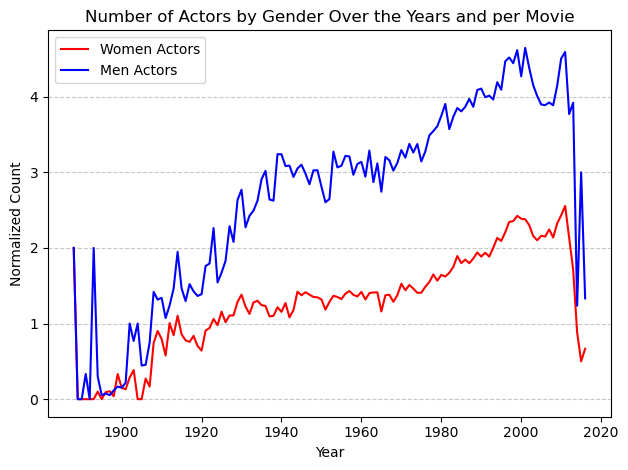

In [30]:
women_actor = CharacterMetadata_df[CharacterMetadata_df['Actor gender'] == 'F']
men_actor = CharacterMetadata_df[CharacterMetadata_df['Actor gender'] == 'M']

count_women = women_actor['Year'].value_counts().sort_index()
count_men = men_actor['Year'].value_counts().sort_index()

all_years = range(min(count_women.index.min(), count_men.index.min()), 
                  max(count_women.index.max(), count_men.index.max()) + 1)

count_women = count_women.reindex(all_years, fill_value=0)
count_men = count_men.reindex(all_years, fill_value=0)

movies_per_year = MovieMetadata_df['Year'].value_counts().sort_index().reindex(all_years, fill_value=0)

plt.plot(count_women.index, count_women.values / movies_per_year.values, label='Women Actors', color='red')
plt.plot(count_men.index, count_men.values / movies_per_year.values, label='Men Actors', color='blue')

plt.xlabel('Year')
plt.ylabel('Normalized Count')
plt.title('Number of Actors by Gender Over the Years and per Movie')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In the previous plot, we calculated the number of male and female actors per year and per movie. Each curve shows the average number of male and female actors per film, normalized by the number of films released that year. We observe that over the years, the number of female actors per film has increased on average but remains lower than the number of male actors since 1900. On average, there are twice as many male actors on screen as female actors.

# Number of Actor by Gender over the Years and per country

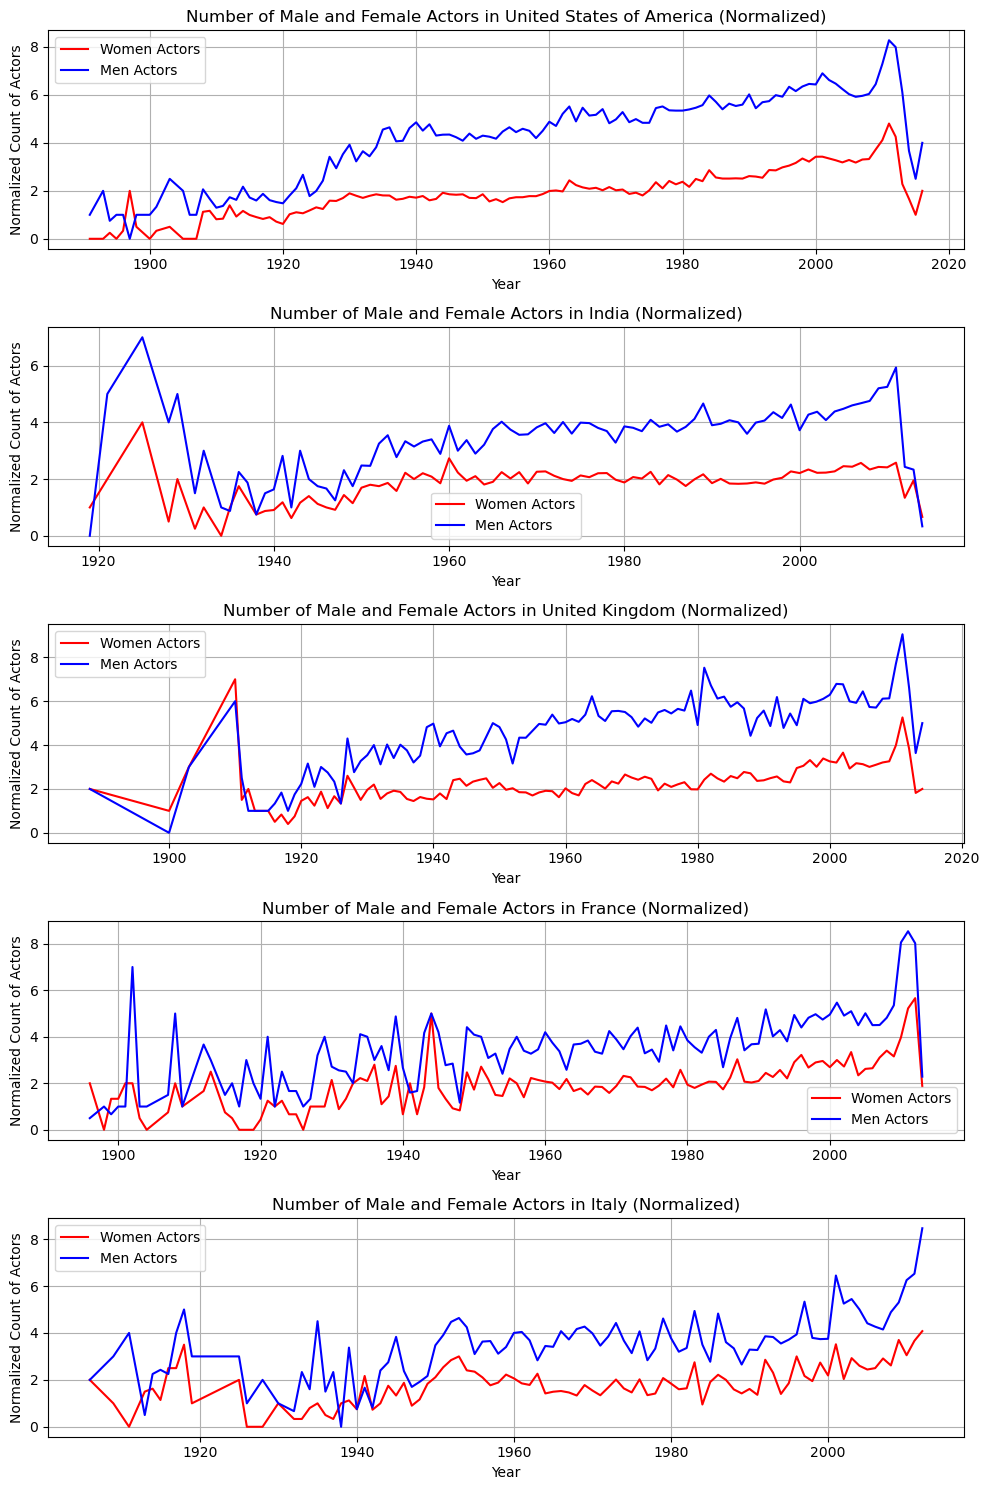

In [29]:
# Step 1: Compute the number of female and male actors in each movies 
count_gender = CharacterMetadata_df.groupby(['Wikipedia movie ID', 'Actor gender']).size().unstack(fill_value=0)

movie_info = CharacterMetadata_df[['Wikipedia movie ID', 'Year', 'Movie countries (Freebase ID:name tuples)', 
                                   'Movie genres (Freebase ID:name tuples)']].drop_duplicates()
# Step 2: Added movie data (country, genre)
result = pd.merge(count_gender, movie_info, on='Wikipedia movie ID', how='left')

result['Country dictionnaire'] = result['Movie countries (Freebase ID:name tuples)'].apply(ast.literal_eval)
result['Genre dictionnaire'] = result['Movie genres (Freebase ID:name tuples)'].apply(ast.literal_eval)

result_exploded = result.explode('Country dictionnaire')
# Step 3: Compute the number of  female and male actors for each country and per year
count_gender = result_exploded.groupby(['Year', 'Country dictionnaire']).agg({'F': 'sum', 'M': 'sum'}).reset_index()

# Step 4: Compute the number of movies per year and per country
movies_per_country = result_exploded.groupby(['Year', 'Country dictionnaire']).size().reset_index(name='movies_count')

count_gender = pd.merge(count_gender, movies_per_country, on=['Year', 'Country dictionnaire'])

# Step 5: Normalisation of the results 
count_gender['F_normalized'] = count_gender['F'] / count_gender['movies_count']
count_gender['M_normalized'] = count_gender['M'] / count_gender['movies_count']

## Step 6: We only take into account the 5 countries that produce the most films
top_countries = count_gender.groupby('Country dictionnaire')['movies_count'].sum().nlargest(5).index
top_countries_data = count_gender[count_gender['Country dictionnaire'].isin(top_countries)]

top_countries_name = ['United States of America', "India", 'United Kingdom', 'France', 'Italy']

fig, axes = plt.subplots(5, 1, figsize=(10, 15))

for i, country in enumerate(top_countries):
    country_data = top_countries_data[top_countries_data['Country dictionnaire'] == country]
    
    axes[i].plot(country_data['Year'], country_data['F_normalized'], label='Women Actors', color='red')
    axes[i].plot(country_data['Year'], country_data['M_normalized'], label='Men Actors', color='blue')
    
    axes[i].set_title(f'Number of Male and Female Actors in {top_countries_name[i]} (Normalized)')
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel('Normalized Count of Actors')
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()

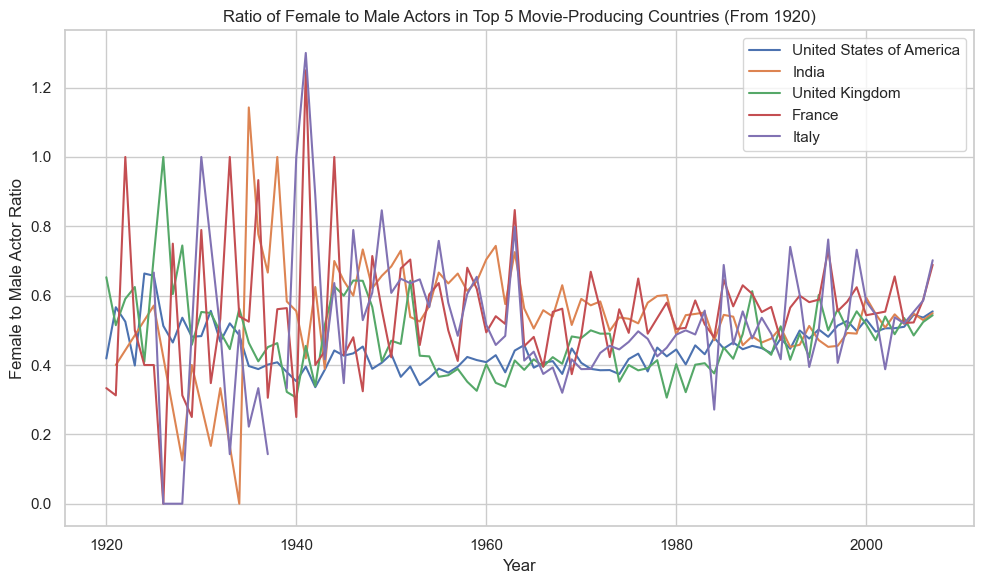

In [39]:
top_countries_data_filtered = top_countries_data[(top_countries_data['Year'] >= 1920) & (top_countries_data['Year'] < 2008) ]

fig, ax = plt.subplots(figsize=(10, 6))

for i, country in enumerate(top_countries):
    country_data = top_countries_data_filtered[top_countries_data_filtered['Country dictionnaire'] == country]
    ax.plot(country_data['Year'], country_data['Ratio'], label=f'{top_countries_name[i]}')

ax.set_title('Ratio of Female to Male Actors in Top 5 Movie-Producing Countries (From 1920)')
ax.set_xlabel('Year')
ax.set_ylabel('Female to Male Actor Ratio')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

This graph illustrates the female-to-male ratio among actors in the five main film-producing countries (United States, India, United Kingdom, France, Italy) since 1920. Overall, women remain underrepresented, with the ratio often below 1. The early decades show significant fluctuations, potentially reflecting social and economic upheavals. From the 1960s onward, a stabilization is observed, but there has been no significant increase in the ratio since then. Differences persist between countries: France and the United Kingdom sometimes display slightly higher ratios than the United States and India. This graph highlights the slow, uneven evolution of women's representation in global cinema, with stagnation in progress over the past few decades.

# Préparation des données pour plot interactif genre/par période/pourcentage actrices

In [51]:
import json

# Function to preprocess genre column
def extract_genres(genre_str):
    try:
        # Convert the genre string (which is in JSON format) to a dictionary
        genre_dict = json.loads(genre_str)
        # Extract genre names from the dictionary (the values)
        genres = list(genre_dict.values())
        return genres
    except Exception as e:
        # In case of an error in parsing, return an empty list or handle the error appropriately
        return []

In [54]:
#result = pd.merge(count_gender, movie_info, on='Wikipedia movie ID', how='left')

result.drop(columns = ['Country dictionnaire', 'Genre dictionnaire'])



,Wikipedia movie ID,F,M,Year,Movie countries (Freebase ID:name tuples),Movie genres (Freebase ID:name tuples),genres
0,330,4,0,1996,"{""/m/06mkj"": ""Spain""}","{""/m/07s9rl0"": ""Drama"", ""/m/01t_vv"": ""Comedy-d...","[Drama, Comedy-drama]"
1,3217,3,10,1992,"{""/m/09c7w0"": ""United States of America""}","{""/m/01q03"": ""Cult"", ""/m/03npn"": ""Horror"", ""/m...","[Cult, Horror, Stop motion, Costume drama, Act..."
2,3333,6,8,1915,"{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film"", ""/m/0219x_"": ""Indi...","[Silent film, Indie, Costume drama, Epic, Blac..."
3,3746,3,11,1982,"{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/01qpc"": ""Cyberpu...","[Thriller, Cyberpunk, Science Fiction, Future ..."
4,3837,2,18,1974,"{""/m/09c7w0"": ""United States of America""}","{""/m/0hfjk"": ""Western"", ""/m/06nbt"": ""Satire"", ...","[Western, Satire, Comedy]"
...,...,...,...,...,...,...,...
63647,37322106,2,1,2012,{},"{""/m/02l7c8"": ""Romance Film"", ""/m/07s9rl0"": ""D...","[Romance Film, Drama]"
63648,37373877,3,3,2006,"{""/m/09c7w0"": ""United States of America""}","{""/m/01q03"": ""Cult"", ""/m/03npn"": ""Horror""}","[Cult, Horror]"
63649,37476824,4,6,2011,"{""/m/03rk0"": ""India""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/016vh2"": ""Ca...","[Crime Fiction, Caper story, Crime Comedy, Com..."
63650,37478048,1,3,1996,{},"{""/m/05p553"": ""Comedy film""}",[Comedy film]


In [53]:
print(result.columns)

Index(['Wikipedia movie ID', 'F', 'M', 'Year',
       'Movie countries (Freebase ID:name tuples)',
       'Movie genres (Freebase ID:name tuples)', 'Country dictionnaire',
       'Genre dictionnaire', 'genres'],
      dtype='object')


In [56]:
# Apply the function to the 'genre' column to extract genre names
result['genres'] = result['Movie genres (Freebase ID:name tuples)'].apply(extract_genres)
#movie_names_summaries_df['genres'] = movie_names_summaries_df['Movie genres (Freebase ID:name tuples)'].apply(extract_genres)

# Exploding the genres into separate rows, as a movie can belong to multiple genres
#genre_feminism_df = feminism_summaries_df.explode('genres')
result= result.explode('genres')


In [69]:

# Drop any rows where the genre is empty or null (optional, depending on your dataset)
#result = result.dropna(subset=['genres'])

# Now the DataFrame has one row for each genre a movie belongs to

# Example check: let's see the result
#print(genre_feminism_df['genres'].unique())

genres_grouped = {
    "Action and Adventure": [
        'Action', 'Action Thrillers', 'Action/Adventure', 'Adventure', 'Action Thriller', 'Adventure Comedy', 'Superhero', 
        'Superhero movie', 'War film', 'War effort', 'Sci-Fi Adventure', 'Sword and sorcery', 'Sword and sorcery films', 
        'Martial Arts Film', 'Heist', 'Combat Films', 'Western', 'B-Western', 'Spaghetti Western', 'Crime Thriller', 
        'Detective fiction', 'Spy', 'Spy Film', 'Action Thrillers'
    ],
    "Drama": [
        'Drama', 'Period piece', 'Family Drama', 'Romantic drama', 'Tragicomedy', 'Courtroom Drama', 
        'Political drama', 'Medical fiction', 'Crime Drama', 'Historical drama', 'Legal drama', 'Political satire', 
        'Inspirational Drama', 'Courtroom Comedy', 'Historical Epic', 'Family-Oriented Adventure', 
        'Social problem film', 'Nature', 'Domestic Comedy', 'Juvenile Delinquency Film', 'Coming of age', 'Childhood Drama',
        'Family & Personal Relationships', 'Americana', 'Roadshow theatrical release', 'Culture & Society', 'Interpersonal Relationships',
        'Teen', 'Addiction Drama',  'Marriage Drama', 'Slice of life story', 
    ],
    "Comedy": [
        'Comedy', 'Screwball comedy', 'Satire', 'Black comedy', 'Romantic comedy', 'Comedy-drama', 
        'Slapstick', 'Comedy Thriller', 'Domestic Comedy', 'Parody', 'Dark Comedy', 'Stand-up comedy', 
        'Slapstick Comedy', 'Comedy film', 'Black-and-white Comedy', 'Comedy of manners', 'Ensemble Film',
        'Comedy of Errors', 'Humour', 'Comedy Western', 'Workplace Comedy', 'Action Comedy', 'Ealing Comedies', 'Mockumentary'
    ],
    "Horror and Thriller": [
        'Horror', 'Thriller', 'Slasher', 'Psychological thriller', 'Zombie Film', 'Supernatural', 
        'Monster movie', 'Crime Thriller', 'Horror Comedy', 'Gothic Film', 'Horror Mystery', 'Psychological horror', 
        'Slasher film', 'Crime Fiction', 'Psycho-biddy', 'Vampire movies', 'Erotic thriller', 'Natural horror films',
        'Comedy horror', 'Costume Horror'
    ],
    "Romance": [
        'Romance Film', 'Romantic fantasy', 'Romantic drama', 'Romantic comedy', 'Love story', 
        'Romantic thriller', 'Fantasy Romance', 'Sex comedy', 'Christmas movie'
    ],
    "Sci-Fi and Fantasy": [
        'Science Fiction', 'Fantasy', 'Fantasy Comedy', 'Sci-Fi Horror', 'Space western', 'Cyberpunk', 'Dystopia', 
        'Alien Film', 'Supernatural', 'Time travel', 'Apocalyptic and post-apocalyptic fiction', 'Steampunk',
        'Fantasy Adventure', 'Neo-noir', 'Surrealism', 'Sci-Fi Thriller', 'Sci Fi Pictures original films'
    ],
    "Family and Kids": [
        'Family Film', 'Animated', 'Children\'s/Family', 'Family-Oriented Adventure', 'Animation', 'Children\'s Fantasy',
        'Animated Musical', 'Family Movie', 'Fairy tale', "Children's", 'Animated cartoon', 'School story', "Children's Issues", 
        "Children's Entertainment", "Children's Film",  'Family-Oriented films', 'Family',
        "Children's Issue"
    ],
    "Documentary": [
        'Documentary', 'Docudrama', 'Biography', 'Educational', 'Music', 'Travel', 'Social issues', 
        'Politics & Society', 'Environmental Science', 'Business', 'Political cinema', 'Historical Documentaries',
        'Health & Fitness', 'World History'
    ],
    "Indie": [
        'Indie', 'Experimental film', 'Avant-garde', 'Art film', 'Independent film', 'Mumblecore', 'Film-Opera', 'Short Film',
        'Experimental Films', 'Psychological Films'
    ],
    "History": [
        'History', 'Historical fiction', 'Biographical film', 'Historical epic', 'Costume drama', 'Historical drama',
        'Biographical film', 'War and Politics', 'WWII Films', 'Political cinema', 'Period Horror'
    ],
    "Cult": [
        'Cult','B-movie','Grindhouse','Blaxploitation','Giallo','Zombie Film','Stoner film','Erotic film','Exploitation film',
        'Pinku eiga', 'Splatter film', 'Gore', 'Erotica', 'Softcore Porn', 'Pornographic movie', 'Hardcore pornography',
        'Gay pornography', 'Gay', 'Gay Interest', 'Erotic Drama', 'Exploitation', 'Glamorized Spy Film', 'Gay Themed'
    ],
    "Crime and Mystery": [
        'Crime Fiction', 'Crime Drama', 'Detective', 'Film noir', 'Mystery', 'Whodunit', 'Crime Comedy', 'Caper story',
        'Legal Drama', 'Crime Thriller', 'Gangster Film', 'Heist', 'Crime', 'Glamorized Spy Film'
    ],
    "Social Issues and Political Films": [
        'Political drama', 'Political satire', 'Political thriller', 'Social issue films', 'Law & Crime', 
        'Gender Issues', 'Political cinema', 'Propaganda film'
    ],
    "Experimental": [
        'Experimental Films', 'Psychological Films', 'Crime Comedy', 'Propaganda Films', 'Sexploitation', 
        'Supernatural Film', 'Detective Fiction', 'Cult Films', 'Anthropology', 'Mondo film', 'Public Domain', 
        'Genre Fiction', 'Bloopers & Candid Camera', 'Screwball comedy', 'Comedy horror'
    ],
    "Feminist Films": [
        'Feminist Film', 'Gender Issues', 'Women in prison films', 'Women’s Studies', 'Feminist cinema', 
        'Women in film', 'Feminist documentary', 'Sexual Politics in Film'
    ],
    "Musical":['Musical', 'Bollywood', 'Musical Drama', 'Hip hop movies', 'Jukebox musical','Punk rock',
               'Backstage Musical', 'Instrumental Music', 'Operetta', 'Punk rock'

    ],
    "Miscellaneous Other Genres": [
        'World cinema', 'Black-and-white', 'Biopic [feature]', 'Film adaptation', 
        'Musical comedy', 'Beach Film', 'Silent film', 'Melodrama', 'Television movie', 
        'Sports', 'LGBT', 'Filipino', 'Filipino Movies', 'Epic', 'Anthology', 'Japanese Movies', 
        'Haunted House Film', 'Tamil cinema', 'The Netherlands in World War II', 'Suspense', 'Erotic comedy', 
        'Tollywood', 'New Hollywood', 'Erotic Drama', 'Erotica', 'Chinese Movies', 
        'Fantasy Drama', 'Pre-Code', 'Neo-noir', 'Buddy film', 'Kitchen sink realism', 'Media Satire', 
        'Computer Animation', 'Christian film', 'Creature Film', 'Remake'
        'Road movie', 'Boxing', 'Stop motion', 'Holiday Film', 'Animal Picture', 'Feature film', 
        'Dogme 95', 'Gross out', 'Road-Horror', 'Disaster', 
        'Natural disaster', 'Anime', 'Chase Movie', 'Escape Film', 'Dance', 
        'Religious Film', 'Samurai cinema', 'Tragedy', 'Monster', 
        'Absurdism', 'British Empire Film', 'Costume Adventure', 'Biker Film', 'Film à clef', 
        'Horse racing', 'Wuxia', 'Heavenly Comedy', 'Cavalry Film', 'Anti-war', 
        'Doomsday film', 'Swashbuckler films', 'Comedy Western', 'Revisionist Western','Archaeology', 'Albino bias', 'Pornography', 'Science fiction Western', 'Hybrid Western', 
        'Exploitation', 'British New Wave', 'Foreign legion', 'Illnesses & Disabilities', 
        'Coming-of-age film', 'Heaven-Can-Wait Fantasies', 'Race movie', 'Movie serial', 'Indian Western', 
        'Bengali Cinema', 'News', 'Czechoslovak New Wave', 'Sponsored film', 'Sword and Sandal', 'Mythological Fantasy', 
        'Roadshow/Carny', 'Fictional film', 'Filmed Play', 'Z movie', 'Parkour in popular culture', 'Essay Film', 
        'Latino', 'Animals', 'Media Studies', 'Prison', 'Goat gland', 'Future noir', 'Auto racing', 'Fan film', 
        'Early Black Cinema', 'Existentialism', 'Airplanes and airports',
        'Revisionist Western', 'Archaeology', 'Albino bias', 'Pornography', 'Gay pornography', 
        'Science fiction Western', 'Hybrid Western', 'Exploitation', 'British New Wave', 'Foreign legion', 
        'Illnesses & Disabilities', 'Coming-of-age film', 'Heaven-Can-Wait Fantasies', 'Race movie', 'Movie serial', 
        'Indian Western', 'Bengali Cinema', 'Gross-out film', 'Adult', 'Remake', 'Road movie', 'Rockumentary', 'Anti-war film',
       'Hagiography', 'Female buddy film', 'Language & Literature',
       'Malayalam Cinema', 'Extreme Sports', 'Jungle Film', 'Film',
       'Film & Television History', 'Prison film', 'Epic Western',
       'Beach Party film', 'Werewolf fiction', 'Archives and records',
       'Acid western', 'Outlaw', 'Northern', 'Supermarionation',
       'Demonic child', 'Kafkaesque', 'Clay animation', 'Concert film',
       'Finance & Investing', 'Bruceploitation', 'Graphic & Applied Arts',
       'Live action', 'Computers', 'Plague', 'Education',
       'Therimin music', 'Libraries and librarians', 'Expressionism',
       'Cold War', 'Point of view shot', 'Buddy cop',
       'Inventions & Innovations', 'Star vehicle', 'New Queer Cinema',
       'Camp', 'Master Criminal Films', 'Comdedy', 'Statutory rape',
       'Alien invasion', 'Journalism', 'Reboot'
    ]
}


# Flatten the genres_grouped dictionary for easy lookup
genre_to_group = {}
for group, genres_list in genres_grouped.items():
    for genre in genres_list:
        genre_to_group[genre] = group

# Function to map each genre to its group
def categorize_genre(genre):
    return genre_to_group.get(genre, 'Other')

# Apply the function to the 'genres' column and create the 'genre_general' column
result['genre_general'] = result['genres'].apply(categorize_genre)

# genre_movie_df['genre_general'] = genre_movie_df['genres'].apply(categorize_genre)


In [70]:
result['Period'] = pd.cut(
    result['Year'], 
    bins=[1940, 1960, 1980, 2020], 
    labels=['1940-1960', '1960-1980', '1980-2020'],
    right=False
)

# Grouper par 'genre_general' et 'Period' puis calculer les sommes de F et M
grouped = result.groupby(['genre_general', 'Period'])[['F', 'M']].sum().reset_index()

# Ajouter les pourcentages
grouped['Total'] = grouped['F'] + grouped['M']
grouped['F_Percentage'] = (grouped['F'] / grouped['Total']) * 100
grouped['M_Percentage'] = (grouped['M'] / grouped['Total']) * 100

# Restructurer les données dans le format souhaité
data = {}
for genre in grouped['genre_general'].unique():
    genre_data = grouped[grouped['genre_general'] == genre]
    periods = {
        period: {
            "Male": genre_data[genre_data['Period'] == period]['M_Percentage'].values[0] if not genre_data[genre_data['Period'] == period].empty else 0,
            "Female": genre_data[genre_data['Period'] == period]['F_Percentage'].values[0] if not genre_data[genre_data['Period'] == period].empty else 0
        }
        for period in ['1940-1960', '1960-1980', '1980-2020']
    }
    data[genre] = periods

# Conversion en DataFrame pour affichage
final_df = pd.DataFrame.from_dict(data, orient='index')

/var/folders/dl/y_0dp4yd3sd1cf5mnxcnpt100000gn/T/ipykernel_31369/1970116402.py:10: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



                                                                           1940-1960  \
Action and Adventure               {'Male': 79.42062179242481, 'Female': 20.57937...   
Comedy                             {'Male': 69.31001589825118, 'Female': 30.68998...   
Crime and Mystery                  {'Male': 70.68300153139356, 'Female': 29.31699...   
Cult                               {'Male': 76.0593220338983, 'Female': 23.940677...   
Documentary                        {'Male': 71.12998040496407, 'Female': 28.87001...   
Drama                              {'Male': 67.55364806866953, 'Female': 32.44635...   
Experimental                       {'Male': 72.07207207207207, 'Female': 27.92792...   
Family and Kids                    {'Male': 76.89305230288836, 'Female': 23.10694...   
Feminist Films                                        {'Male': 50.0, 'Female': 50.0}   
History                            {'Male': 71.11283443195036, 'Female': 28.88716...   
Horror and Thriller             

In [72]:
from dash import Dash, dcc, html, Input, Output
import plotly.graph_objs as go
import pandas as pd

genres = final_df.index.tolist()
periods = final_df.columns.tolist()

# Initialisation de l'application Dash
app = Dash(__name__)

# Mise en page
app.layout = html.Div([
    html.H1("Actor Gender Repartition per Movie Genre and Period", style={'textAlign': 'center'}),
    dcc.Graph(id="pie-chart"),
    html.Div([
        html.Label("Select Genre:"),
        dcc.Dropdown(
            id="genre-dropdown",
            options=[{"label": genre, "value": genre} for genre in genres],
            value=genres[0],  # Genre par défaut
            clearable=False,  # Empêche de désélectionner
        ),
    ], style={"margin-bottom": "20px", "width": "50%"}),  # Limite la largeur du Dropdown pour un meilleur affichage
    html.Div([
        html.Label("Select Period:"),
        dcc.Dropdown(
            id="period-dropdown",
            options=[{"label": period, "value": period} for period in periods],
            value=periods[0],  # Première période par défaut
        ),
    ], style={"margin-bottom": "20px", "width": "50%"}),  # Limite également la largeur de ce Dropdown
])

# Callback pour mettre à jour le graphique
@app.callback(
    Output("pie-chart", "figure"),
    [Input("genre-dropdown", "value"), Input("period-dropdown", "value")]
)
def update_pie_chart(selected_genre, selected_period):
    # Récupérer les données pour le genre et la période sélectionnés
    data = final_df.loc[selected_genre, selected_period]
    male_percentage = data['Male']
    female_percentage = data['Female']
    
    # Créer le graphique
    labels = ["Male", "Female"]
    values = [male_percentage, female_percentage]
    
    fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=0.4)])
    fig.update_layout(
        title=f"Genre: {selected_genre} | Period: {selected_period}",
        title_x=0.5,
    )
    return fig

# Lancer l'application
if __name__ == "__main__":
    app.run_server(debug=True)

In [73]:
female_total = 0
count = 0 

# Parcourir les données
for genre in final_df.index:
    for period in final_df.columns:
        data = final_df.loc[genre, period]
        female_total += data['Female']
        count += 1

# Calcul des moyennes
female_avg = female_total / count

print(f"Female Average Percentage: {female_avg}%")

Female Average Percentage: 31.44219093775743%
